In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import admix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import string
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from os.path import join
import json
from scipy.stats import combine_pvalues
from statsmodels.stats.meta_analysis import combine_effects

In [2]:
var_g_scale_factor = 0.24884752564563367

In [3]:
def meta_analysis(effects, se, method="random", weights=None):
    # From Omer Weissbrod
    assert method in ["fixed", "random"]
    d = effects
    variances = se ** 2

    # compute random-effects variance tau2
    vwts = 1.0 / variances
    fixedsumm = vwts.dot(d) / vwts.sum()
    Q = np.sum(((d - fixedsumm) ** 2) / variances)
    df = len(d) - 1
    tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))

    # defing weights
    if weights is None:
        if method == "fixed":
            wt = 1.0 / variances
        else:
            wt = 1.0 / (variances + tau2)
    else:
        wt = weights

    # compute summtest
    summ = wt.dot(d) / wt.sum()
    if method == "fixed":
        varsum = np.sum(wt * wt * variances) / (np.sum(wt) ** 2)
    else:
        varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
    ###summtest = summ / np.sqrt(varsum)

    summary = summ
    se_summary = np.sqrt(varsum)

    return summary, se_summary

In [4]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-tmp")
trait_list = trait_info["trait"].values
dict_trait_display_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}

In [5]:
ROOT_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr"
)

trait_list = [
    f.split("/")[-1].split(".")[0] for f in glob.glob(join(ROOT_DIR, "pheno", "*.tsv"))
]

In [6]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio with delta method, est[1] (rho) / est[0] (var_g)

    est: (2, ) numpy array
    est_var (2, 2) variance-covariance matrix
    """

    assert len(est) == 2
    assert est_var.shape == (2, 2)
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var)


def estimate_hsq(dict_est, scale_factor=1):
    """
    Estimate the ratio with delta method, est[0] (var_g) / [est[0] (var_g) + est[1] (var_e)]
    est: (2, ) numpy array
    est_var (2, 2) variance-covariance matrix
    """

    if len(dict_est["est"]) == 2:
        assert np.all(dict_est["est"].Source.values == ["V(G)", "V(e)"])
        est = dict_est["est"].Variance.values
        est_var = dict_est["varcov"].values
    elif len(dict_est["est"]) == 3:
        assert np.all(dict_est["est"].Source.values == ["V(G1)", "V(G2)", "V(e)"])
        est = dict_est["est"].Variance.values[[0, 2]]
        est_var = dict_est["varcov"].values[np.ix_([0, 2], [0, 2])]

    x, y = est[0], est[1]
    hsq = (x * scale_factor) / (x * scale_factor + y)
    # grad = [y / (x + y)^2, - x / (x + y)^2]
    grad = np.array(
        [
            scale_factor * y / ((scale_factor * x + y) ** 2),
            -scale_factor * x / ((scale_factor * x + y) ** 2),
        ]
    )

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return hsq, quad_form(grad, est_var)

In [33]:
df_plot = {
    "trait": [],
    "n_indiv": [],
    "rg": [],
    "rg_stderr": [],
    "snpset": [],
    "hermodel": [],
    "full_hsq": [],
    "full_hsq_stderr": [],
    "reduced_hsq": [],
    "reduced_hsq_stderr": [],
    "pval_delta": [],
    "pval_lrt": [],
}

for trait in trait_list:
    for snpset in ["imputed"]:
        for hermodel in ["mafukb", "gcta"]:
            reml_file = f"out/gcta-estimate/{trait}.{snpset}.{hermodel}"
            if trait in [
                "total_wbc_cnt",
                "neutrophil",
                "basophil_cnt",
                "monocyte_cnt",
                "eosinophil_cnt",
            ]:
                reml_file += ".duffy_covar"

            # REML allowing for heterogeneity
            full_est = admix.tools.gcta.read_reml(reml_file)
            rg, rg_var = estimate_rg(
                full_est["est"]["Variance"].iloc[0:2], full_est["varcov"].iloc[0:2, 0:2]
            )
            rg_stderr = np.sqrt(rg_var)

            # reduced reml (one component)
            reduced_est = admix.tools.gcta.read_reml(reml_file + ".reduced")

            # heritability
            ## full model
            full_hsq, full_hsq_var = estimate_hsq(
                full_est, scale_factor=var_g_scale_factor
            )
            reduced_hsq, reduced_hsq_var = estimate_hsq(
                reduced_est, scale_factor=var_g_scale_factor
            )

            # p-values
            pval_lrt = stats.chi2.sf(
                2 * (full_est["loglik"] - reduced_est["loglik"]), 1
            )
            pval_delta = stats.norm.cdf((rg - 1) / rg_stderr)

            # other info
            n_indiv = full_est["n"]

            # fill in data for plotting
            df_plot["trait"].append(trait)
            df_plot["snpset"].append(snpset)
            df_plot["hermodel"].append(hermodel)
            df_plot["n_indiv"].append(n_indiv)

            # genetic-cor
            df_plot["rg"].append(rg)
            df_plot["rg_stderr"].append(rg_stderr)

            # p-values for genet-cor
            df_plot["pval_lrt"].append(pval_lrt)
            df_plot["pval_delta"].append(pval_delta)

            # hsq
            df_plot["full_hsq"].append(full_hsq)
            df_plot["full_hsq_stderr"].append(np.sqrt(full_hsq_var))

            df_plot["reduced_hsq"].append(reduced_hsq)
            df_plot["reduced_hsq_stderr"].append(np.sqrt(reduced_hsq_var))


df_plot = pd.DataFrame(df_plot)

In [42]:
df_tbl = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")].copy()
df_tmp = df_tbl[df_tbl.iloc[:, 1] > 4000]
# df_tmp = df_tbl.copy()
print(len(df_tmp))
print(meta_analysis(df_tmp["rg"], df_tmp["rg_stderr"]))

32
(0.9700121046238048, 0.01650682592392893)


In [8]:
df_tbl = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")].copy()

df_tbl = df_tbl[
    [
        "trait",
        "n_indiv",
        "reduced_hsq",
        "reduced_hsq_stderr",
        "rg",
        "rg_stderr",
        "pval_lrt",
    ]
].rename(columns={"pval_lrt": "pval"})

df_tbl.to_csv("results/admix-corr.csv", index=False)
# meta-analysis results
meta_mean, meta_se = meta_analysis(df_tbl["rg"], df_tbl["rg_stderr"])

df_tbl = df_tbl.append(
    {
        "trait": "Meta-analysis",
        "n_indiv": 0,
        "rg": meta_mean,
        "rg_stderr": meta_se,
        "pval": stats.norm.cdf((meta_mean - 1) / meta_se),
    },
    ignore_index=True,
)

df_tbl["trait"] = df_tbl["trait"].apply(
    lambda x: dict_trait_display_name[x] if x in dict_trait_display_name else x
)
df_tbl["n_indiv"] = df_tbl["n_indiv"].astype(int)
for col in ["rg", "rg_stderr", "reduced_hsq", "reduced_hsq_stderr", "pval"]:
    df_tbl[col] = df_tbl[col].apply(lambda x: f"{x:.3f}")


df_tbl = df_tbl.rename(
    columns={
        "trait": "Phenotype",
        "n_indiv": "$N$",
        "rg": "$\widehat{r_g}$",
        "rg_stderr": "$\widehat{\text{s.e.}(r_g)}$",
        "reduced_hsq": "$\widehat{h_g^2}$",
        "reduced_hsq_stderr": "$\widehat{\text{s.e.}(h_g^2)}$",
        "pval": "$p$-value",
    }
)

In [10]:
print(df_tbl.to_latex(escape=False, index=False))

\begin{tabular}{lrlllll}
\toprule
               Phenotype &   $N$ & $\widehat{h_g^2}$ & $\widehat{\text{s.e.}(h_g^2)}$ & $\widehat{r_g}$ & $\widehat{\text{s.e.}(r_g)}$ & $p$-value \\
\midrule
      C-reactive protein &  8521 &             0.270 &                          0.042 &           0.983 &                        0.059 &     0.762 \\
          Basophil count &  3276 &             0.055 &                          0.093 &           1.285 &                        0.119 &     0.103 \\
              HbA$_{1c}$ &  1854 &             0.167 &                          0.156 &           1.183 &                        0.209 &     0.537 \\
             Adiponectin &  2908 &             0.174 &                          0.103 &          -0.607 &                        6.431 &     0.080 \\
        Eosinophil count &  3276 &             0.163 &                          0.096 &           1.150 &                        0.087 &     0.238 \\
                     IL6 &  1811 &             0.258 &   

# Consistency of estimate with different assumed genetic architecture

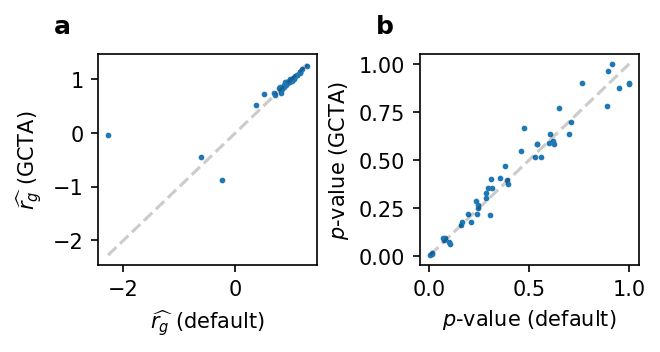

In [13]:
df_tbl1 = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")].drop(
    columns=["snpset", "hermodel"]
)
df_tbl2 = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "gcta")].drop(
    columns=["snpset", "hermodel"]
)

fig, axes = plt.subplots(figsize=(4.5, 2.5), dpi=150, ncols=2)

for i, (k, label) in enumerate(
    zip(["rg", "pval_lrt"], ["$\widehat{r_g}$", "$p$-value"])
):
    axes[i].scatter(df_tbl1[k], df_tbl2[k], s=3)
    axes[i].set_xlabel(f"{label} (default)")
    axes[i].set_ylabel(f"{label} (GCTA)")

    lim = [
        min(df_tbl1[k].min(), df_tbl2[k].min()),
        max(df_tbl1[k].max(), df_tbl2[k].max()),
    ]

    # annotation
    axes[i].text(
        -0.2,
        1.1,
        string.ascii_lowercase[i],
        transform=axes[i].transAxes,
        size=12,
        weight="bold",
    )
    axes[i].plot([lim[0], lim[1]], [lim[0], lim[1]], "k--", alpha=0.2)

fig.tight_layout()
# plt.savefig("results/real-genome-wide-assumption-robust.pdf", bbox_inches="tight")

In [14]:
# different subset of traits for meta-analysis

In [57]:
df_tbl = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "gcta")].drop(
    columns=["snpset", "hermodel"]
)
df_tbl["hsq_z"] = df_tbl["reduced_hsq"] / df_tbl["reduced_hsq_stderr"]
hsq_z_threshold = -stats.norm.ppf(0.05 / len(df_tbl))
# hsq_z_threshold = -stats.norm.ppf(0.05)

df_tbl2 = df_tbl[df_tbl.hsq_z <= hsq_z_threshold]

In [62]:
df_tbl1 = df_tbl[df_tbl.hsq_z > hsq_z_threshold]
meta_mean, meta_se = meta_analysis(df_tbl1["rg"], df_tbl1["rg_stderr"])
print(f"{len(df_tbl1)} traits with hsq > 0: {meta_mean:.3f} ({meta_se:.3f})")

24 traits with hsq > 0: 0.945 (0.016)


In [64]:
df_tbl2 = df_tbl[df_tbl.hsq_z < hsq_z_threshold]
meta_mean, meta_se = meta_analysis(df_tbl2["rg"], df_tbl2["rg_stderr"])
print(f"{len(df_tbl2)} traits with hsq > 0: {meta_mean:.3f} ({meta_se:.3f})")

22 traits with hsq > 0: 1.093 (0.029)


In [41]:
df_tbl2

,trait,n_indiv,rg,rg_stderr,full_hsq,full_hsq_stderr,reduced_hsq,reduced_hsq_stderr,pval_delta,pval_lrt,hsq_z
3,basophil_cnt,3276,1.243252,0.081864,0.243310,0.147737,0.096438,0.144026,0.998518,0.063790,0.669593
5,a1c,1854,1.184392,0.235983,0.246409,0.230142,0.197265,0.218014,0.782710,0.583882,0.904827
7,adiponectin,2908,-0.448916,6.175835,0.055557,0.211764,0.258355,0.142338,0.407255,0.092749,1.815080
9,eosinophil_cnt,3276,1.129598,0.072483,0.344321,0.137452,0.269857,0.131559,0.963111,0.217317,2.051233
11,il6,1811,-0.042314,2.866234,0.140347,0.317337,0.422319,0.201263,0.358059,0.092865,2.098345
15,mean_cell_hgb,3816,0.825082,0.459445,0.128554,0.144555,0.166746,0.118722,0.351707,0.596701,1.404511
19,mean_corp_vol,3816,0.797613,0.462477,0.135172,0.145597,0.180940,0.120123,0.330832,0.514948,1.506288
25,neutrophil,3279,0.862230,0.236275,0.251437,0.153291,0.333312,0.114657,0.279916,0.374706,2.907032
31,rbc_dist_width,3813,0.842374,0.266662,0.211852,0.135712,0.269775,0.109657,0.277224,0.403457,2.460162
43,gout,10479,1.005846,0.522621,0.021825,0.058533,0.021337,0.044650,0.504462,1.000000,0.477870
